Mô hình dữ liệu x theo dạng bậc 6

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mapFeature(x1, x2, degree=6):
    out = [np.ones(x1.shape[0])]
    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((x1 ** (i - j)) * (x2 ** j))
    return np.stack(out, axis=1)

1. Chia dữ liệu ra thành 2 tập: training (70%) và validation (30%). Phải đảm bảo việc chia dữ liệu là ngẫu nhiên và tỷ lệ positive và negative cân bằng.

In [22]:
df = pd.read_csv('data5.txt', header=None)
df.columns = ['x1', 'x2', 'y']

x1 = df['x1'].values
x2 = df['x2'].values
y = df['y'].values.astype(int)

X_poly = mapFeature(x1, x2)

def normalize_features(X):
    X_norm = X.copy()
    mean = np.mean(X[:, 1:], axis=0)
    std = np.std(X[:, 1:], axis=0)
    X_norm[:, 1:] = (X[:, 1:] - mean) / std
    return X_norm, mean, std

X_norm, mu, sigma = normalize_features(X_poly)

def balanced_split(X, y, train_ratio=0.7):
    idx_0 = np.where(y == 0)[0]
    idx_1 = np.where(y == 1)[0]
    np.random.seed(1)
    np.random.shuffle(idx_0)
    np.random.shuffle(idx_1)
    n0 = int(len(idx_0) * train_ratio)
    n1 = int(len(idx_1) * train_ratio)
    train_idx = np.concatenate((idx_0[:n0], idx_1[:n1]))
    val_idx = np.concatenate((idx_0[n0:], idx_1[n1:]))
    np.random.shuffle(train_idx)
    np.random.shuffle(val_idx)
    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]

X_train, y_train, X_val, y_val = balanced_split(X_norm, y)

train_data = np.hstack((X_train, y_train.reshape(-1, 1)))
val_data = np.hstack((X_val, y_val.reshape(-1, 1)))

np.savetxt("train_data.txt", train_data, fmt="%.6f", delimiter=',')
np.savetxt("val_data.txt", val_data, fmt="%.6f", delimiter=',')

2. Viết chương trình cho phép học các tham số của mô hình phân loại phi tuyến trên có sử dụng regularization L2 và L1.

In [23]:
train_data = np.loadtxt('train_data.txt', delimiter=',')
X_train = train_data[:, :-1]
y_train = train_data[:, -1]

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(theta, X_norm, y, lambd=0.0, regularization='l2'):
    m = len(y)
    h = sigmoid(X_norm @ theta)
    epsilon = 1e-8  # log(0)

    cost = -np.mean(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))

    # skip theta[0]
    if regularization == 'l2':
        reg = (lambd / (2 * m)) * np.sum(theta[1:] ** 2)
    elif regularization == 'l1':
        reg = (lambd / m) * np.sum(np.abs(theta[1:]))
    else:
        reg = 0

    return cost + reg

def compute_gradient(theta, X_norm, y, lambd=0.0, regularization='l2'):
    m = len(y)
    h = sigmoid(X_norm @ theta)
    error = h - y
    grad = (1 / m) * (X_norm.T @ error)

    if regularization == 'l2':
        grad[1:] += (lambd / m) * theta[1:]
    elif regularization == 'l1':
        grad[1:] += (lambd / m) * np.sign(theta[1:])

    return grad

def train_logistic_regression(X_norm, y, lambd=0.0, regularization='l2', alpha=0.1, num_iters=1000):
    theta = np.zeros(X_norm.shape[1])
    J_history = []

    for i in range(num_iters):
        grad = compute_gradient(theta, X_norm, y, lambd, regularization)
        theta -= alpha * grad
        J = compute_cost(theta, X_norm, y, lambd, regularization)
        J_history.append(J)
        
        if i % 100 == 0:
            print(f"Iteration {i}: J = {J:.6f}")

    return theta, J_history

theta_l2, J_l2_history = train_logistic_regression(
    X_train, y_train, lambd=0.1, regularization='l2', alpha=0.5, num_iters=1000
)

theta_l1, J_l1_history = train_logistic_regression(
    X_train, y_train, lambd=0.1, regularization='l1', alpha=0.1, num_iters=1000
)

print("J (L2):", J_l2_history[-1])
print("J (L1):", J_l1_history[-1])

Iteration 0: J = 0.615010
Iteration 100: J = 0.332595
Iteration 200: J = 0.313965
Iteration 300: J = 0.307606
Iteration 400: J = 0.304584
Iteration 500: J = 0.302908
Iteration 600: J = 0.301891
Iteration 700: J = 0.301236
Iteration 800: J = 0.300794
Iteration 900: J = 0.300485
Iteration 0: J = 0.672215
Iteration 100: J = 0.435794
Iteration 200: J = 0.389033
Iteration 300: J = 0.366656
Iteration 400: J = 0.353458
Iteration 500: J = 0.344742
Iteration 600: J = 0.338636
Iteration 700: J = 0.334112
Iteration 800: J = 0.330608
Iteration 900: J = 0.327810
J (L2): 0.30026385106676134
J (L1): 0.3255418669420802


3. Tính J ở mỗi vòng lặp cho cả hai tập, chọn điểm dừng phù hợp.

Iter 0: J_train = 0.61501, J_val = 0.58664
Iter 100: J_train = 0.33259, J_val = 0.43834
Iter 200: J_train = 0.31396, J_val = 0.47821
Iter 300: J_train = 0.30761, J_val = 0.50602
Iter 400: J_train = 0.30458, J_val = 0.52464
Iter 500: J_train = 0.30291, J_val = 0.53763
Iter 600: J_train = 0.30189, J_val = 0.54712
Iter 700: J_train = 0.30124, J_val = 0.55431
Iter 800: J_train = 0.30079, J_val = 0.55992
Iter 900: J_train = 0.30049, J_val = 0.56442


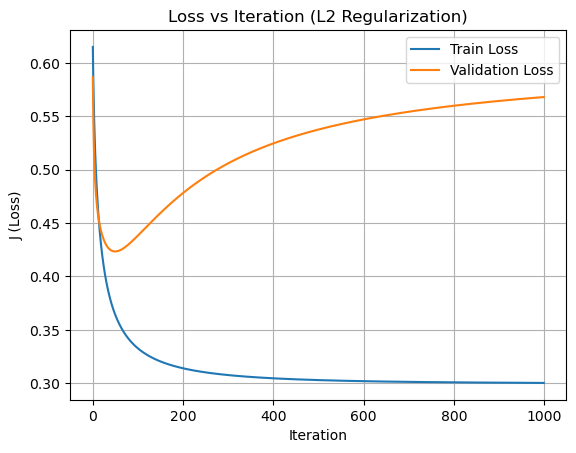

In [24]:
train_data = np.loadtxt('train_data.txt', delimiter=',')
X_train = train_data[:, :-1]
y_train = train_data[:, -1]

val_data = np.loadtxt('val_data.txt', delimiter=',')
X_val = val_data[:, :-1]
y_val = val_data[:, -1]

def train_with_validation(X_train, y_train, X_val, y_val, lambd=0.1, regularization='l2',
                          alpha=0.1, num_iters=1000, tol=1e-5):
    theta = np.zeros(X_train.shape[1])
    J_train_hist = []
    J_val_hist = []
    
    for i in range(num_iters):
        grad = compute_gradient(theta, X_train, y_train, lambd, regularization)
        theta -= alpha * grad

        J_train = compute_cost(theta, X_train, y_train, lambd, regularization)
        J_val   = compute_cost(theta, X_val, y_val, lambd, regularization)
        
        J_train_hist.append(J_train)
        J_val_hist.append(J_val)

        if i % 100 == 0:
            print(f"Iter {i}: J_train = {J_train:.5f}, J_val = {J_val:.5f}")
        
        # if i > 10 and abs(J_val_hist[-2] - J_val_hist[-1]) < tol:
        #     break

    return theta, J_train_hist, J_val_hist

theta_l2, J_train_l2, J_val_l2 = train_with_validation(
    X_train, y_train, X_val, y_val,
    lambd=0.1, regularization='l2',
    alpha=0.5, num_iters=1000
)

plt.plot(J_train_l2, label='Train Loss')
plt.plot(J_val_l2, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('J (Loss)')
plt.title('Loss vs Iteration (L2 Regularization)')
plt.legend()
plt.grid(True)
plt.show()


4. Thay đổi lambda và tính J cho mỗi lambda tương ứng cho cả hai tập. Vẽ biểu đồ quan hệ giữa J và lambda từ đó lựa chọn lambda phù hợp.

Iter 0: J_train = 0.61497, J_val = 0.58656
Iter 100: J_train = 0.32419, J_val = 0.42696
Iter 200: J_train = 0.30077, J_val = 0.46534
Iter 300: J_train = 0.29115, J_val = 0.49519
Iter 400: J_train = 0.28567, J_val = 0.51686
Iter 500: J_train = 0.28203, J_val = 0.53310
Iter 600: J_train = 0.27938, J_val = 0.54577
Iter 700: J_train = 0.27734, J_val = 0.55605
Iter 800: J_train = 0.27571, J_val = 0.56466
Iter 900: J_train = 0.27436, J_val = 0.57207
Iter 0: J_train = 0.61498, J_val = 0.58657
Iter 100: J_train = 0.32505, J_val = 0.42815
Iter 200: J_train = 0.30217, J_val = 0.46675
Iter 300: J_train = 0.29295, J_val = 0.49645
Iter 400: J_train = 0.28778, J_val = 0.51786
Iter 500: J_train = 0.28441, J_val = 0.53380
Iter 600: J_train = 0.28201, J_val = 0.54618
Iter 700: J_train = 0.28019, J_val = 0.55617
Iter 800: J_train = 0.27877, J_val = 0.56449
Iter 900: J_train = 0.27760, J_val = 0.57159
Iter 0: J_train = 0.61499, J_val = 0.58659
Iter 100: J_train = 0.32677, J_val = 0.43049
Iter 200: J_trai

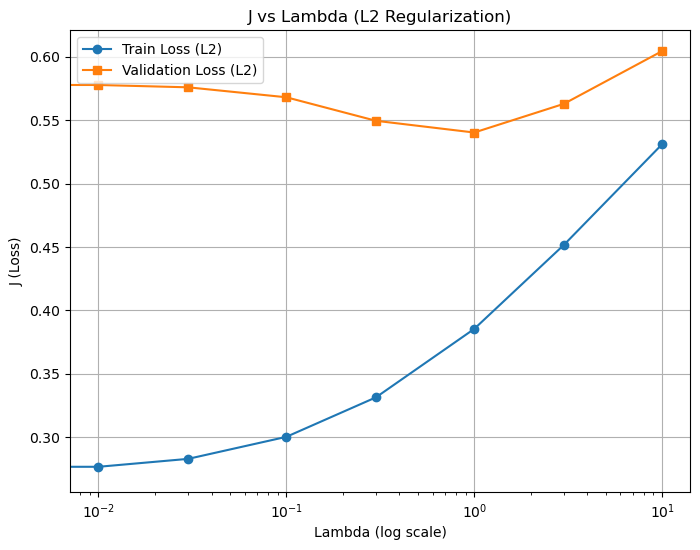

In [25]:
lambda_values = [0, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
J_train_l2_list = []
J_val_l2_list = []

for lambd in lambda_values:
    _, J_train_l2, J_val_l2 = train_with_validation(
        X_train, y_train, X_val, y_val,
        lambd=lambd,
        regularization='l2',
        alpha=0.5,
        num_iters=1000
    )
    J_train_l2_list.append(J_train_l2[-1]) 
    J_val_l2_list.append(J_val_l2[-1])

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
plt.plot(lambda_values, J_train_l2_list, label='Train Loss (L2)', marker='o')
plt.plot(lambda_values, J_val_l2_list, label='Validation Loss (L2)', marker='s')
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('J (Loss)')
plt.title('J vs Lambda (L2 Regularization)')
plt.grid(True)
plt.legend()
plt.show()
